# PAM GtACR1, starved flies

In [1]:
import numpy as np
import os
import time
import scipy
import glob
import sys
from datetime import datetime
import matplotlib as mpl
mpl.use('nbagg')
import seaborn as sns
import pylab as pl

import importlib
import pandas as pd
import scipy.stats as spstats

# import some custom funcs
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import utils as util
import behavior as butil

In [2]:
importlib.reload(util)
util.set_sns_style(style='dark')
%matplotlib notebook

In [3]:
# if util.get_os() == 'Linux':
#     rootdir = '/home/julianarhee/edgetracking-googledrive/Edge_Tracking/Data'
# elif util.get_os() == 'Darwin':
#     rootdir = '/home/julianarhee/Library/CloudStorage/GoogleDrive-edge.tracking.ru@gmail.com/My Drive/Edge_Tracking/Data'
# else:
#     rootdir=None
#     print("Unknown os: {}".format(util.get_os()))
rootdir = util.get_rootdir()
experiment = 'PAM_GtACR1'

src_dir = os.path.join(rootdir, experiment)
# # src_dir = '/Users/julianarhee/Documents/rutalab/data/test'
# print(src_dir)
fig_id = os.path.join('/Edge_Tracking', rootdir.split('/Edge_Tracking/')[1], experiment)
print(fig_id)
savedir = '{}/jyr/{}'.format(rootdir, experiment)
savedir = savedir.replace(" ", "")
figdir = os.path.join(savedir, 'figures')
print("Saving figures to:{}    {}".format('\n', figdir))
if not os.path.exists(figdir):
    os.makedirs(figdir)

/Edge_Tracking/Data/PAM_GtACR1
Saving figures to:
    /home/julianarhee/edgetracking-googledrive/Edge_Tracking/Data/jyr/PAM_GtACR1/figures


In [ ]:
select_logs = [
    '10292021-142308_PAMGTACR1_thresh_lights_LT_Fly2_002.log',
    '10292021-143856_PAMGTACR1_thresh_lights_LT_Fly2_003.log',
    '11102021_Fly1/11102021-104614_PAMGtACR1_thresh_lights_old_food_yeast_Fly1_001.log',
    '11102021-110114_PAMGTACR1_thresh_lights_old_food_yeast_Fly1_002.log',
    '11102021-134854_PAMGtACR1_thresh_lights_old_food_yeast_Fly2_001.log',
    '11102021-140908_PAMGtACR1_thresh_lights_old_food_yeast_Fly2_002.log',
    '11122021-151822_PAMGtACR1_Fly1_001.log',
    '11122021-151822_PAMGtACR1_Fly1_001.log',
    '11152021-150321_PAMGtACR1_Fly1_002.log',
    '11152021-153105_PAMGtACR1_Fly1_003.log',
    '11162021-104332_PAMGTACR1_Fly1_001.log',
    '11162021-105012_PAMGtACR1_Fly1_002.log',
]

In [4]:
importlib.reload(butil)

<module 'behavior' from '/home/julianarhee/Repositories/plume-tracking/behavior.py'>

In [12]:
importlib.reload(gdrive)

<module 'google_drive' from '/home/julianarhee/Repositories/plume-tracking/google_drive.py'>

#### GtACR1 has specified files from Andy

In [13]:
print(experiment)
logdf = gdrive.get_info_from_gsheet(experiment)
logdf.shape

PAM_GtACR1
1ZGPrQSciyYYftOqrHcKMGQTu9jh7gb5OY0I0_W0EmW0
COMPLETE: Data copied


(62, 5)

In [45]:
logdf['filepath'] = None
#curr_fns = logdf[logdf['experiment']=='inside']['log'].values
curr_fns = logdf['log'].values
for fn in curr_fns:
    found_files=[]
    try:
        found_files = glob.glob(os.path.join(src_dir, '*/*/{}'.format(fn)))
        assert len(found_files)==1, "No file found, checking one dir up."
    except AssertionError as e:
        found_files = glob.glob(os.path.join(src_dir, '*/{}'.format(fn)))
        assert len(found_files)==1, "No file found: {}.".format(fn)
    if len(found_files)==1:
        logdf.loc[logdf['log']==fn, 'filepath'] = found_files[0] 

In [49]:
import shutil
copy_files=False
if copy_files:
    if not os.path.exists(os.path.join(savedir, 'raw')):
        os.makedirs(os.path.join(savedir, 'raw'))
    for fpath in logdf['filepath'].values:
        fbase = os.path.split(fpath)[-1]
        shutil.copy(fpath, os.path.join(savedir, 'raw', fbase))

In [51]:
src_dir = os.path.join(savedir, 'raw')
sorted(os.listdir(src_dir), key=util.natsort)

['10262021-113334_PAMGtACR1_thresh_lights_on_Fly1_001.log',
 '10262021-114313_PAMGTACR1_thresh_no_lights_Fly1_002.log',
 '10262021-120011_PAMGtACR1_lights_outside_Fly1_003.log',
 '10262021-125040_PAMGtACR1_no_lights_strip.log',
 '10272021-150422_PAMGtACR1_no_lights_Fly1_001.log',
 '10272021-151514_PAMGtACR1_thresh_lights_on_Fly1_002.log',
 '10272021-154410_PAMGTACR1_thresh_lights_Fly1_003.log',
 '10272021-160023_PAMGtACR1_thresh_lights_LT_early_Fly1_004.log',
 '10272021-160508_PAMGTACR1_thresh_lights_on_Fly1_005.log',
 '10272021-161524_PAM_GTACR1_thresh_lights_on_Fly1_007.log',
 '10272021-163421PAMGTACR1_thresh_lights_on_outside_LT_Fly1_008.log',
 '10272021-164059_PAMGTACR1_thresh_lights_on_inside_LT_Fly1_009.log',
 '10282021-141515_PAMGTACR1_thresh_lights_on_LT_Fly1_001.log',
 '10282021-142840_PAMGtACR1_thresh_lights_on_Fly1_002.log',
 '10282021-144631_PAMgtACR1_thresh_lights_on_Fly_003.log',
 '10282021-145553_PAMGTACR1_thresh_comp_crash_Fly1_004.log',
 '10282021-151217_PAMGtACR1_thre

In [112]:
importlib.reload(butil)

<module 'behavior' from '/home/julianarhee/Repositories/plume-tracking/behavior.py'>

In [113]:
fpath

'/home/julianarhee/edgetracking-googledrive/Edge_Tracking/Data/jyr/PAM_GtACR1/raw/10292021-142308_PAMGTACR1_thresh_lights_LT_Fly2_002.log'

In [114]:
fn = '10292021-142308_PAMGTACR1_thresh_lights_LT_Fly2_002.log'
fpath = os.path.join(src_dir, fn)
df0 = pd.read_csv(fpath, encoding='latin' )
df = butil.load_dataframe(fpath, experiment=experiment)
df = butil.correct_manual_conditions(df, experiment, logdf=logdf)
df = butil.process_df(df)
print(df0.columns)

[WARNING] ['10292021-142308_PAMGTACR1_thresh_lights_LT_Fly2_002']: Found bad skips, removing 175 of 30959 samples.
--> found bad skips in FTs, check: 10292021-142308_PAMGTACR1_thresh_lights_LT_Fly2_002
Correcting experiment conditions: PAM_GtACR1
Index(['timestamp -- motor_step_command', 'mfc1_stpt', 'mfc2_stpt',
       'mfc3_stpt', 'led1_stpt', 'led2_stpt', 'sig_status', 'ft_posx',
       'ft_posy', 'ft_frame', 'ft_error', 'ft_roll', 'ft_pitch', 'ft_yaw',
       'ft_heading', 'instrip'],
      dtype='object')


In [115]:
df['condition'].unique()

array(['inside'], dtype=object)

<IPython.core.display.Javascript object>


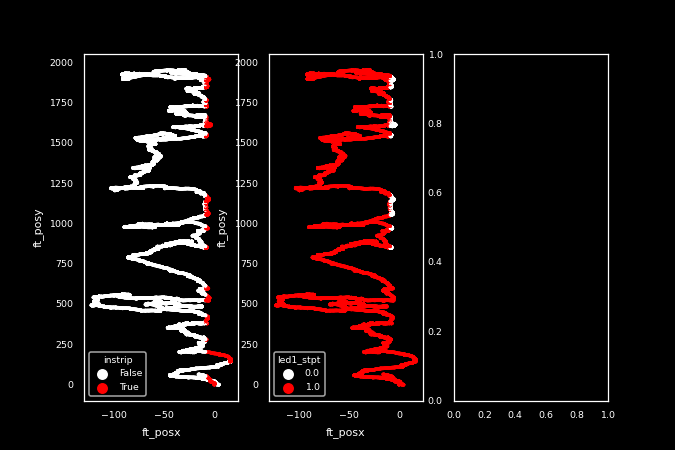

<IPython.core.display.Javascript object>


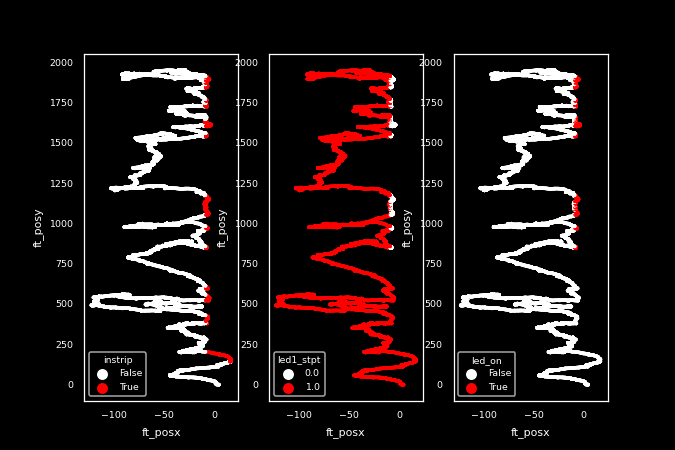

<AxesSubplot: xlabel='ft_posx', ylabel='ft_posy'>

In [108]:
fig, axn = pl.subplots(1,3)
sns.scatterplot(data=df0, x='ft_posx', y='ft_posy', hue='instrip', ax=axn[0],
                palette={True: 'r', False: 'w'}, s=5, edgecolor='none')
sns.scatterplot(data=df0, x='ft_posx', y='ft_posy', hue='led1_stpt', ax=axn[1],
                palette={True: 'r', False: 'w'}, s=5, edgecolor='none')

fig, axn = pl.subplots(1,3)
sns.scatterplot(data=df, x='ft_posx', y='ft_posy', hue='instrip', ax=axn[0],
                palette={True: 'r', False: 'w'}, s=5, edgecolor='none')
sns.scatterplot(data=df, x='ft_posx', y='ft_posy', hue='led1_stpt', ax=axn[1],
                palette={True: 'r', False: 'w'}, s=5, edgecolor='none')
sns.scatterplot(data=df, x='ft_posx', y='ft_posy', hue='led_on', ax=axn[2],
                palette={True: 'r', False: 'w'}, s=5, edgecolor='none')

In [82]:
df['date']

0        20211029
1        20211029
2        20211029
3        20211029
4        20211029
           ...   
30779    20211029
30780    20211029
30781    20211029
30782    20211029
30783    20211029
Name: date, Length: 30784, dtype: int64

In [72]:
df['led2_stpt'].unique()

array([0.])

In [53]:
df = butil.process_df(df, 

In [62]:
df['odor_on'].unique()

array([False,  True])

In [ ]:
fig, ax= pl.subplots()


In [116]:
log_files = butil.get_log_files(src_dir=src_dir, experiment=experiment, verbose=False, is_gdrive=False,
                        return_loginfo=False)

Checking parent dir.
Found 62 tracking files.


In [202]:
importlib.reload(butil)

<module 'behavior' from '/home/julianarhee/Repositories/plume-tracking/behavior.py'>

In [203]:
strip_width=50
strip_sep=200
# is_csv = False
df0_all = butil.load_combined_df(log_files=log_files, logdf=logdf, 
                                 src_dir=src_dir,
                                is_csv=False, experiment=experiment, 
                                savedir=savedir, save_errors=False, create_new=True,
                                parse_filename=True, remove_invalid=True, process=True)
#df0_all = df0_all.rename(columns={'Unnamed: 0': 'frame'})
df0_all.loc[df0_all['condition']=='outisde', 'condition'] = 'outside'
df0_all.loc[df0_all['condition']=='inisde', 'condition'] = 'inside'
condition_list = df0_all['condition'].unique()
print("Found {} conditions:".format(len(condition_list)))
for c in condition_list:
    print(c)

Processing 62 tracking files.
[WARNING] ['10262021-113334_PAMGtACR1_thresh_lights_on_Fly1_001']: Found bad skips, removing 60 of 16116 samples.
[WARNING] ['10272021-160023_PAMGtACR1_thresh_lights_LT_early_Fly1_004']: Found bad skips, removing 8 of 7399 samples.
[WARNING] ['10272021-161524_PAM_GTACR1_thresh_lights_on_Fly1_007']: Found bad skips, removing 15738 of 23710 samples.
[WARNING] ['10272021-163421PAMGTACR1_thresh_lights_on_outside_LT_Fly1_008']: Found bad skips, removing 49 of 9715 samples.
[WARNING] ['10282021-141515_PAMGTACR1_thresh_lights_on_LT_Fly1_001']: Found bad skips, removing 2598 of 26848 samples.
[WARNING] ['10282021-160632_PAMGTACR1_thresh_lights_on_Fly2_003']: Found bad skips, removing 5561 of 20352 samples.
[WARNING] ['10292021-121350_PAMGtACR1_thresh_lights_wanders_off_LT_Fly1_002']: Found bad skips, removing 120 of 14142 samples.
[WARNING] ['10292021-140440_PAMGtACR1_thresh_lights_on_error_LT_Fly2_001']: Found bad skips, removing 3545 of 31240 samples.
[WARNING] 

In [204]:
df0_all['fly_id'].unique()

array(['20211026-fly1', '20211027-fly2', '20211028-fly3', '20211028-fly4',
       '20211029-fly6', '20211029-fly5', '20211110-fly14',
       '20211110-fly13', '20211112-fly12', '20211115-fly11',
       '20211116-fly10', '20211116-fly8', '20211116-fly9',
       '20211118-fly7'], dtype=object)

In [205]:
# if 'fly' in logdf.columns:
#     for fi, df_ in df.groupby('filename'):
#         explicit_fly_id = logdf.loc[logdf['log']=='{}.log'.format(fi)]['fly'].unique()[0]
#         datestr = df_['date'].unique()[0]
#         curr_id = df['fly_id'].unique()[0]
#         print("Renaming: {} to {}".format(curr_id, '{}-fly{}'.format(datestr, explicit_fly_id)))
#         df.loc[df['filename']==fi, 'fly_id'] = '{}-fly{}'.format(datestr, explicit_fly_id)


In [144]:
importlib.reload(butil)

<module 'behavior' from '/home/julianarhee/Repositories/plume-tracking/behavior.py'>

<IPython.core.display.Javascript object>


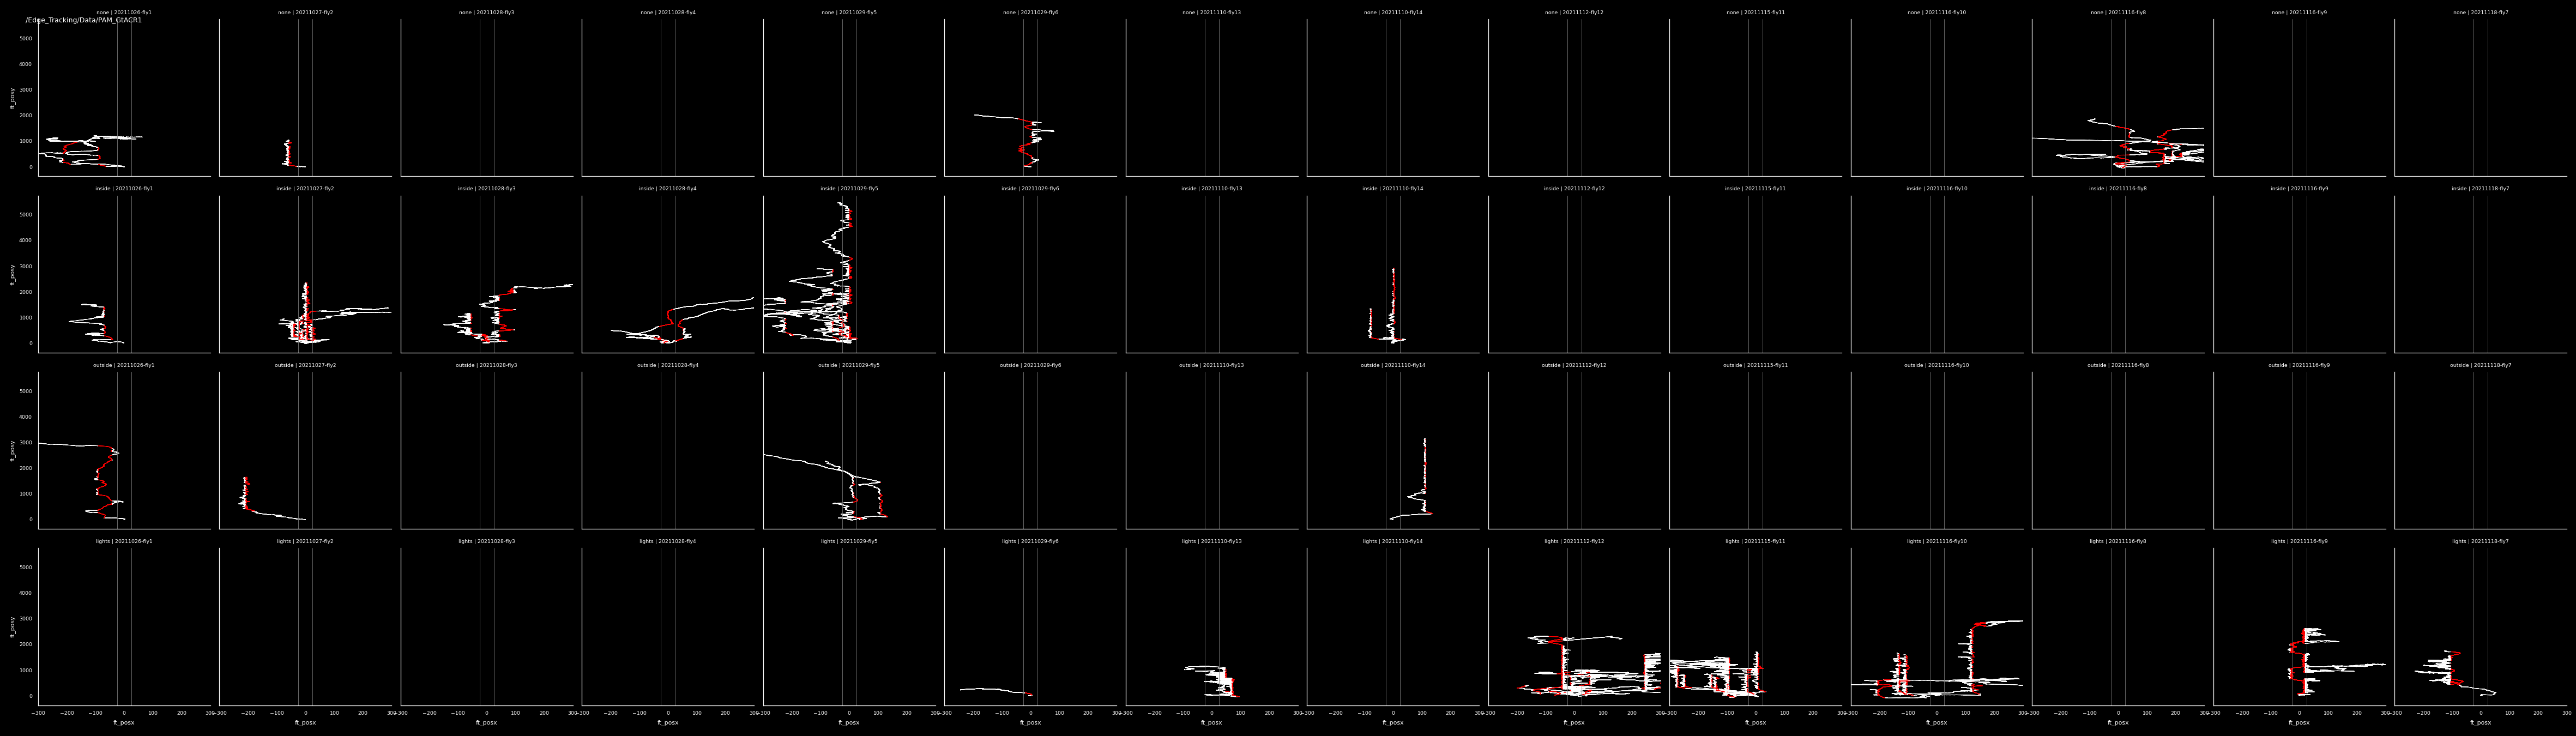

/home/julianarhee/edgetracking-googledrive/Edge_Tracking/Data/jyr/PAM_GtACR1/figures traj-all-by-cond


In [207]:

# plot fly x cond
fig = butil.plot_fly_by_condition(df0_all, strip_width=strip_width,
                row_order=['none', 'inside', 'outside', 'lights'])
# save
figname = 'traj-all-by-cond'
util.label_figure(fig, fig_id)
pl.savefig(os.path.join(figdir, '{}.png'.format(figname))) #, dpi=dpi)
print(figdir, figname)


In [163]:
df0_all.columns

Index(['timestamp -- motor_step_command', 'mfc1_stpt', 'mfc2_stpt',
       'mfc3_stpt', 'led1_stpt', 'led2_stpt', 'sig_status', 'ft_posx',
       'ft_posy', 'ft_frame', 'ft_error', 'ft_roll', 'ft_pitch', 'ft_yaw',
       'ft_heading', 'instrip', 'filename', 'fpath', 'timestamp',
       'motor_step_command', 'time', 'rel_time', 'date', 'odor_on',
       'strip_type', 'led_on', 'experiment', 'fly_name', 'condition', 'trial',
       'fly_id', 'trial_id', 'boutnum', 'cum_time', 'speed', 'upwind_speed',
       'crosswind_speed', 'euclid_dist', 'upwind_dist', 'crosswind_dist',
       'bout_type'],
      dtype='object')

In [208]:
# currcond = 'inside'
# df = df0_all[df0_all['condition']==currcond].copy()
# len(df['fly_id'].unique())
#
select_logs = [
    '10292021-142308_PAMGTACR1_thresh_lights_LT_Fly2_002.log',
    '10292021-143856_PAMGTACR1_thresh_lights_LT_Fly2_003.log',
    '11102021_Fly1/11102021-104614_PAMGtACR1_thresh_lights_old_food_yeast_Fly1_001.log',
    '11102021-110114_PAMGTACR1_thresh_lights_old_food_yeast_Fly1_002.log',
    '11102021-134854_PAMGtACR1_thresh_lights_old_food_yeast_Fly2_001.log',
    '11102021-140908_PAMGtACR1_thresh_lights_old_food_yeast_Fly2_002.log',
    '11122021-151822_PAMGtACR1_Fly1_001.log',
    '11122021-151822_PAMGtACR1_Fly1_001.log',
    '11152021-150321_PAMGtACR1_Fly1_002.log',
    '11152021-153105_PAMGtACR1_Fly1_003.log',
    '11162021-104332_PAMGTACR1_Fly1_001.log',
    '11162021-105012_PAMGtACR1_Fly1_002.log',
]

# make output dirs for figures
if not os.path.exists(os.path.join(figdir, 'selected')):
    os.makedirs(os.path.join(figdir, 'selected'))
incl_logs = [os.path.splitext(f)[0] for f in select_logs]

if not os.path.exists(os.path.join(figdir, 'inside_lights')):
    os.makedirs(os.path.join(figdir, 'inside_lights'))

only_selected=False    
# select dataset
if only_selected:    
    df = df0_all[df0_all['filename'].isin(incl_logs)].copy()
    curr_figdir = os.path.join(figdir, 'selected')
else:
    df = df0_all[df0_all['condition'].isin(['inside', 'lights'])].copy()
    curr_figdir = os.path.join(figdir, 'inside_lights')
len(df['fly_id'].unique())

13

In [209]:
instrip_palette = {True: 'r', False: 'w'}

<IPython.core.display.Javascript object>


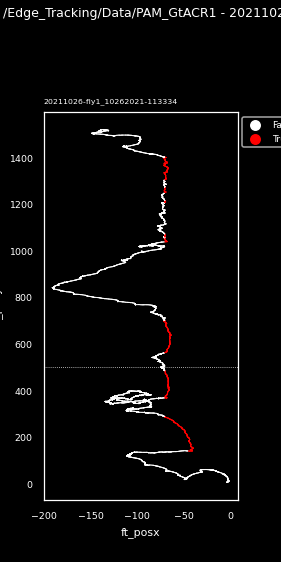

<IPython.core.display.Javascript object>


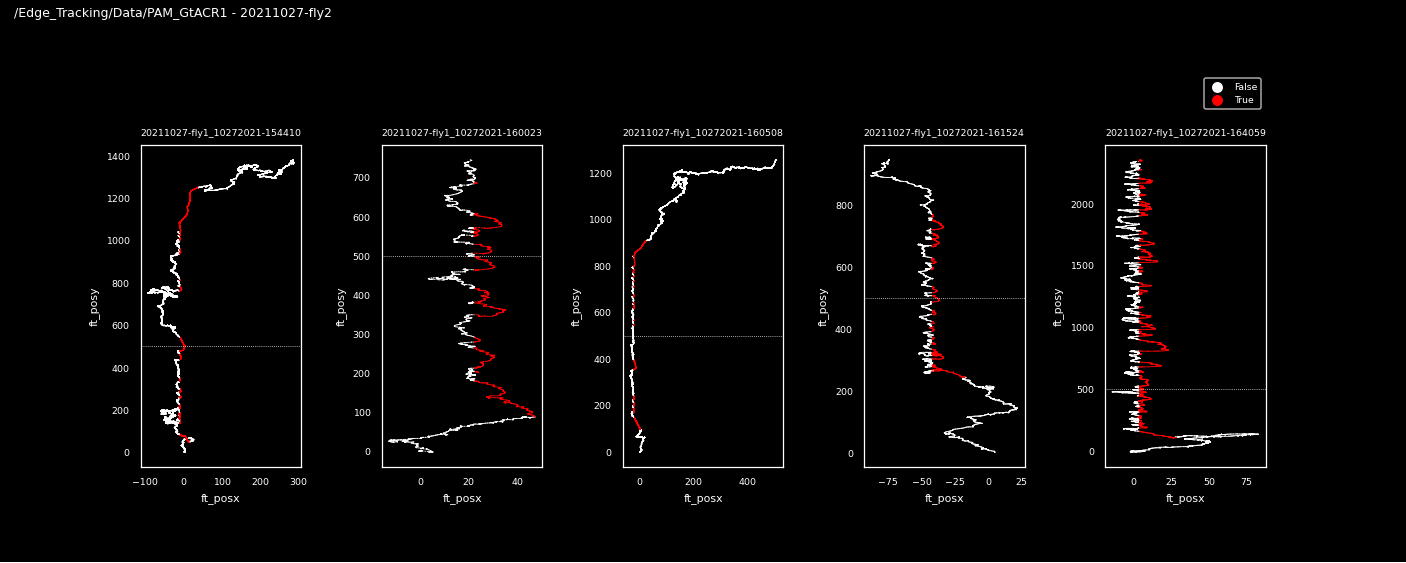

<IPython.core.display.Javascript object>


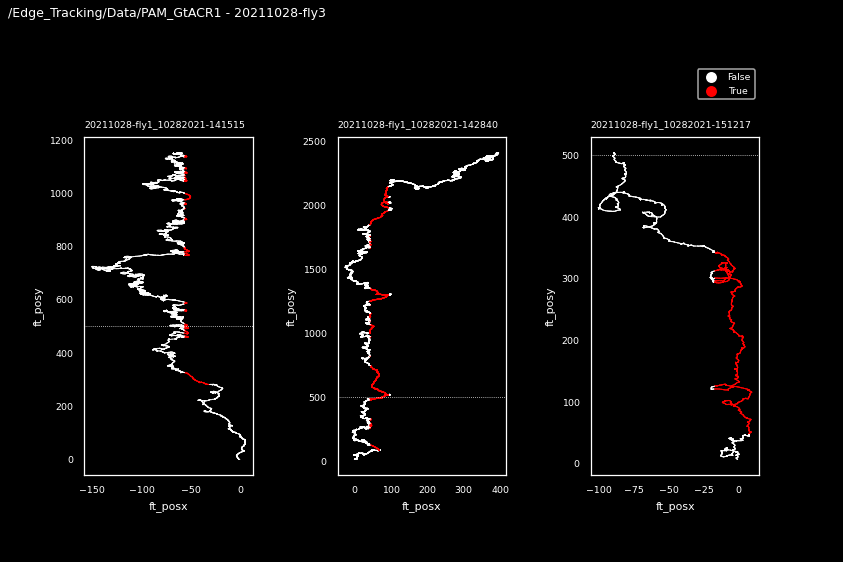

<IPython.core.display.Javascript object>


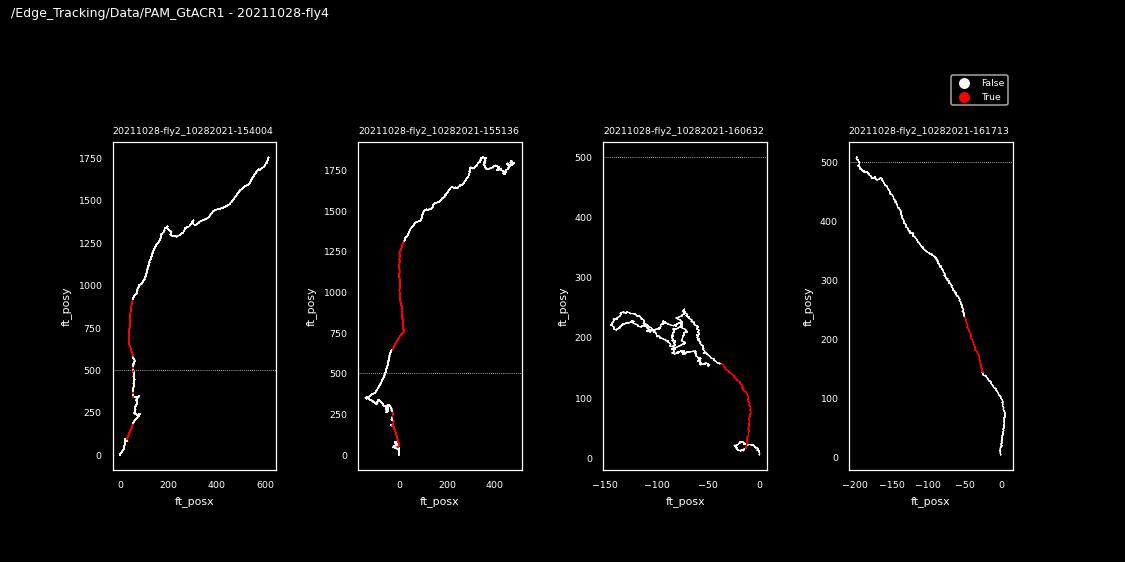

<IPython.core.display.Javascript object>


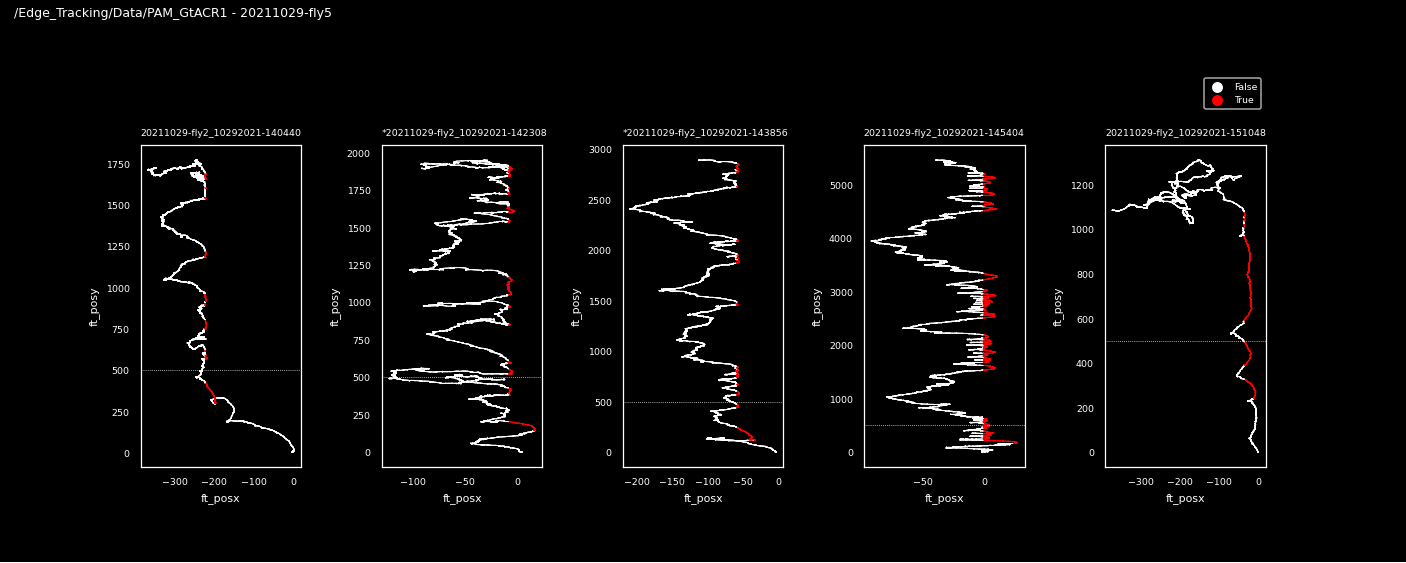

<IPython.core.display.Javascript object>


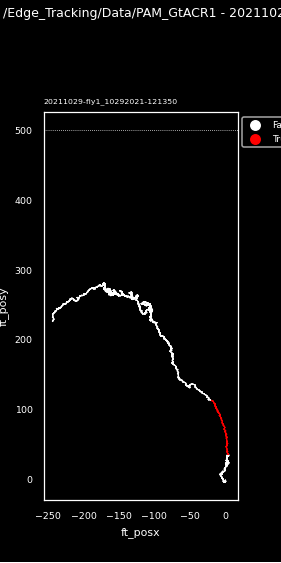

<IPython.core.display.Javascript object>


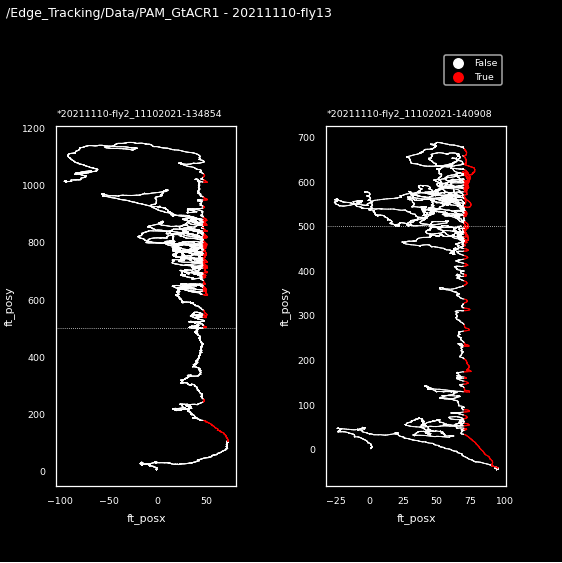

<IPython.core.display.Javascript object>


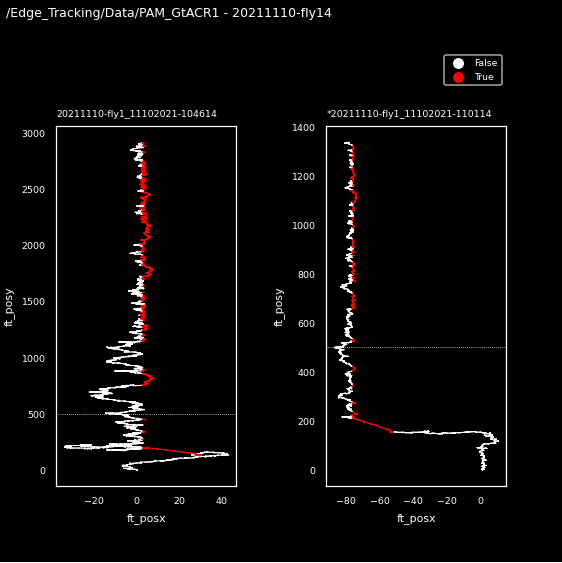

<IPython.core.display.Javascript object>


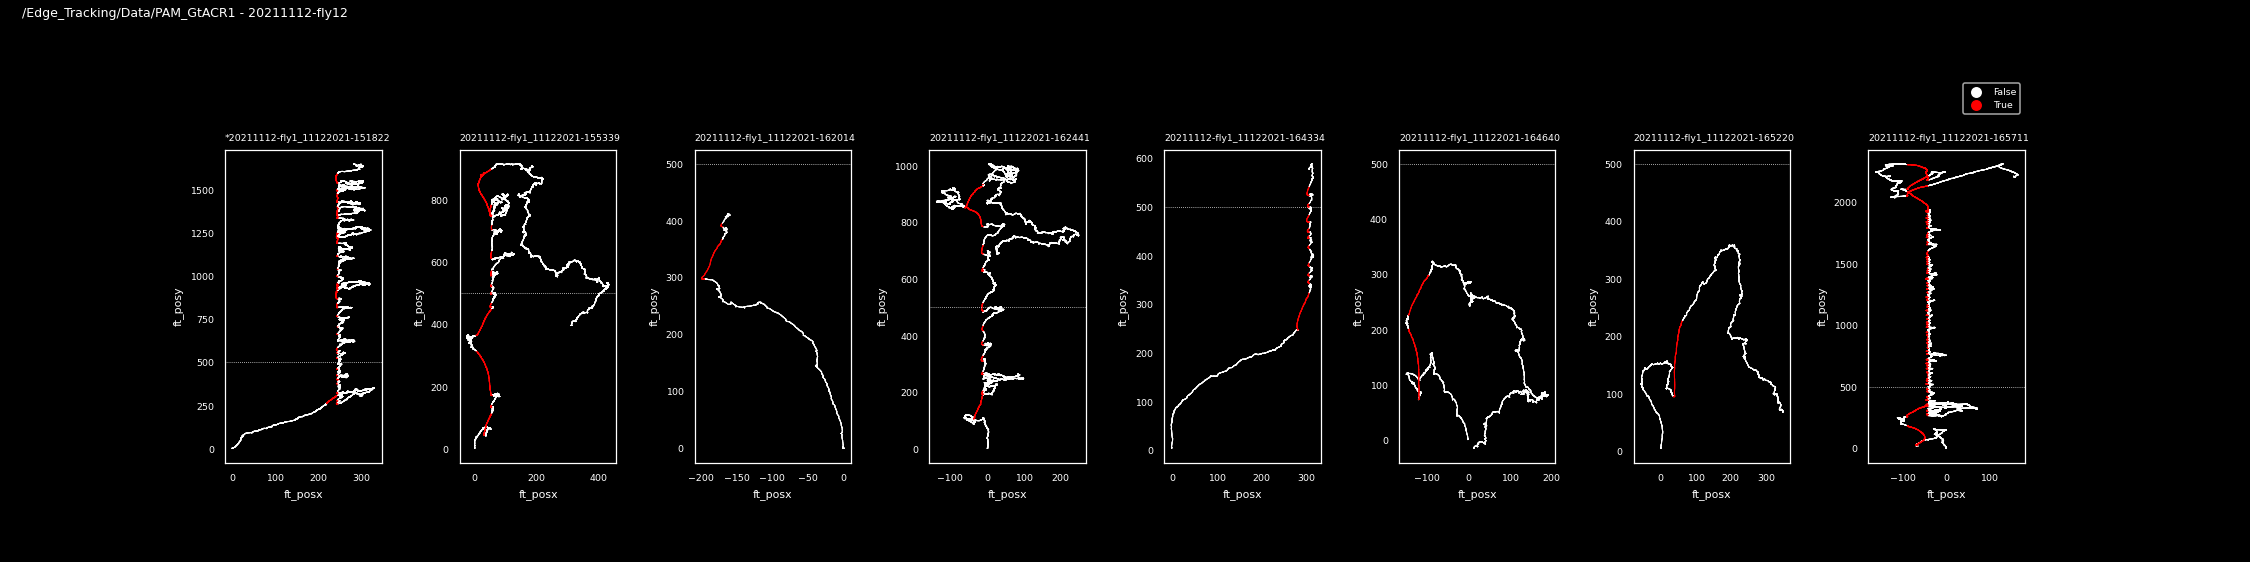

<IPython.core.display.Javascript object>


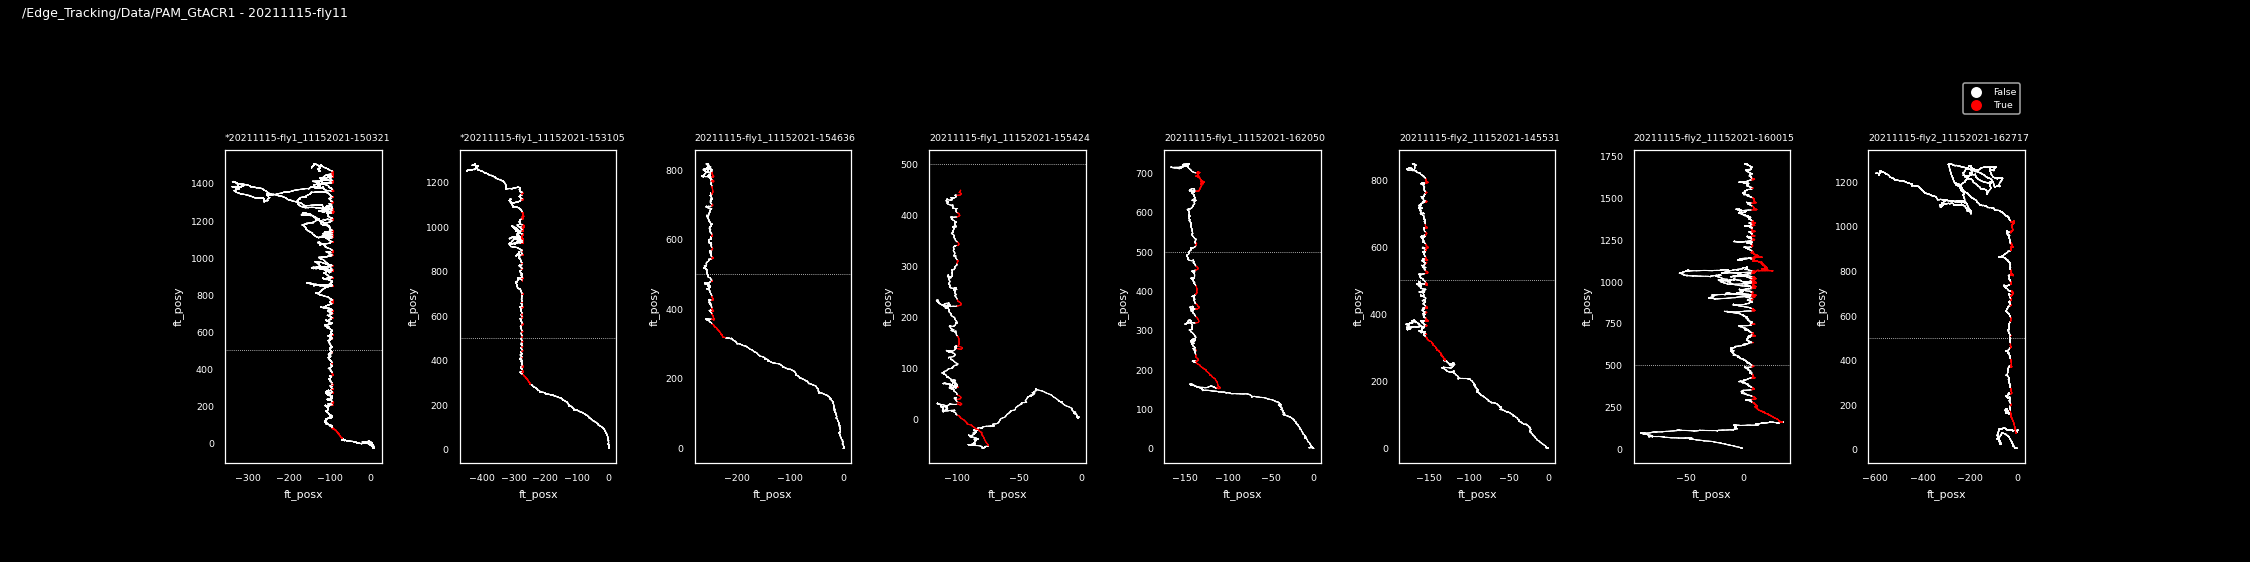

<IPython.core.display.Javascript object>


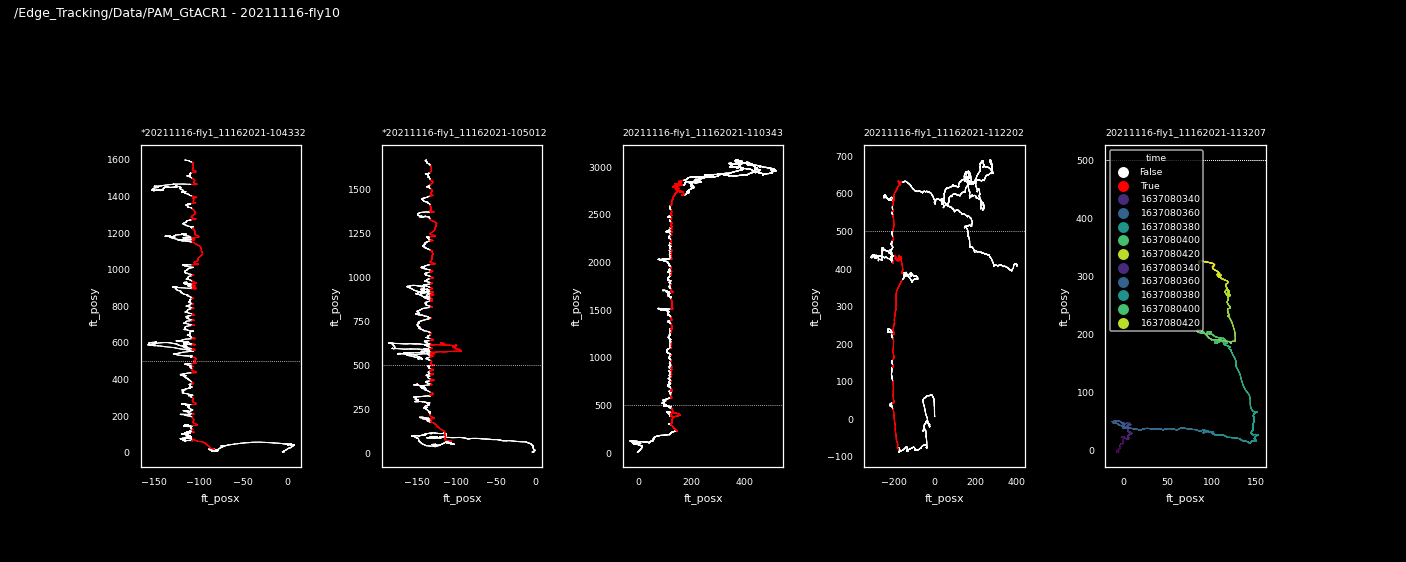

<IPython.core.display.Javascript object>


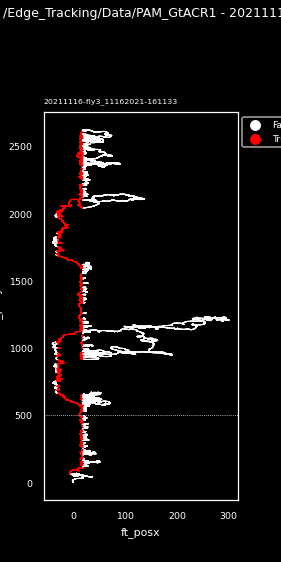

<IPython.core.display.Javascript object>


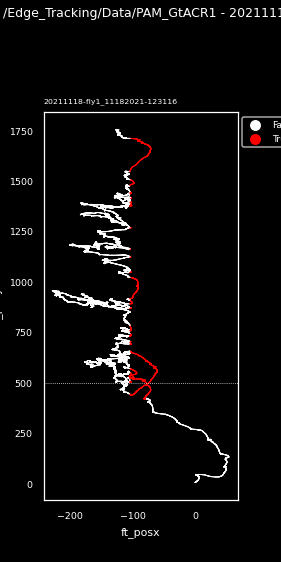

In [210]:

# g = sns.FacetGrid(df, col='trial_id', row='fly_id', aspect=0.5)
# g.map_dataframe(sns.scatterplot, x="ft_posx", y="ft_posy", hue='instrip',
#             s=0.5, edgecolor='none', palette=instrip_palette) #, palette=palette)
# g.set_titles(row_template = '{row_name}', col_template = '{col_name}', size=6)

for fly_id, df_ in df.groupby('fly_id'):
    ntrials = len(df_['trial_id'].unique())
    fig, axn = pl.subplots(1, ntrials, figsize=(ntrials*2.5, 5))
    if len(df_['trial_id'].unique())==1:
        sns.scatterplot(data=df_, x="ft_posx", y="ft_posy", hue='instrip', ax=axn,
                        s=.5, edgecolor='none', palette=instrip_palette)
        axn.set_box_aspect(2)
        axn.axhline(y=500, linestyle=':', c='w', linewidth=0.5)
        if df_['filename'].unique()[0] in incl_logs:
            plot_title = '*{}'.format(df_['trial_id'].unique()[0])
        else:
            plot_title = df_['trial_id'].unique()[0]
        axn.set_title(plot_title, fontsize=5, loc='left')
        axn.legend(bbox_to_anchor=(1,1), loc='upper left')
    else:
        for ai, (ax, (trial_id, tdf_)) in enumerate(zip(axn.flat, df_.groupby('trial_id'))):
            sns.scatterplot(data=tdf_, x="ft_posx", y="ft_posy", hue='instrip', ax=ax,
                            s=.5, edgecolor='none', palette=instrip_palette)
            ax.set_box_aspect(2)
            ax.axhline(y=500, linestyle=':', c='w', linewidth=0.5)
            if tdf_['filename'].unique()[0] in incl_logs:
                plot_title = '*{}'.format(tdf_['trial_id'].unique()[0])
            else:
                plot_title = tdf_['trial_id'].unique()[0]
            ax.set_title(plot_title, fontsize=6, loc='left')
            if ai == (ntrials-1):
                ax.legend(bbox_to_anchor=(1,1.1), loc='lower right')
            else:
                ax.legend_.remove()
    pl.subplots_adjust(left=0.1, right=0.9, wspace=0.5, top=0.8)
    util.label_figure(fig, '{} - {}'.format(fig_id, fly_id))
    pl.savefig(os.path.join(curr_figdir, '{}.png'.format(fly_id)))

In [211]:
fly_id = '20211110-fly13'
df_ = df[df['fly_id']==fly_id].copy()
df_['trial_id'].unique()
    

array(['20211110-fly2_11102021-134854', '20211110-fly2_11102021-140908'],
      dtype=object)

<IPython.core.display.Javascript object>


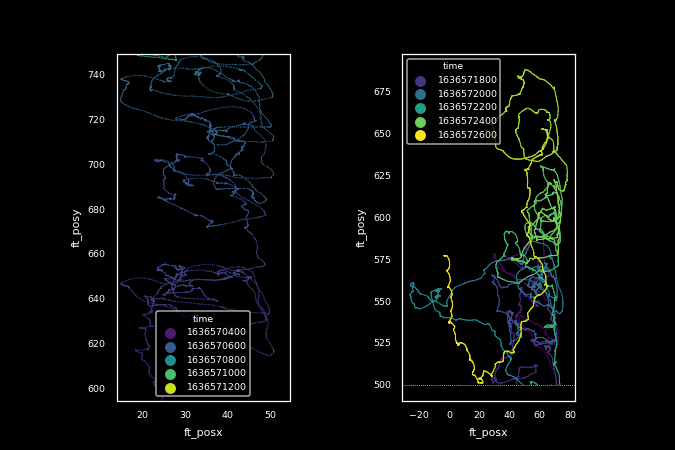

/tmp/ipykernel_449349/955767943.py:3: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for ax, (trial_id, d_) in zip(axn.flat, df_.groupby(['trial_id'])):


In [217]:
n_trials = len(df_['trial_id'].unique())
fig, axn = pl.subplots(1, n_trials)
for ax, (trial_id, d_) in zip(axn.flat, df_.groupby(['trial_id'])):
    plotdf=d_[d_['ft_posy']>=500].copy()
    sns.scatterplot(data=plotdf, x="ft_posx", y="ft_posy", hue='time', ax=ax,
                    s=.5, edgecolor='none', palette='viridis')
    ax.set_box_aspect(2)
    ax.axhline(y=500, linestyle=':', c='w', linewidth=0.5)

In [243]:
strip_borders={}
for trial_id, d_ in df_.groupby('trial_id'):
    curr_borders = butil.find_strip_borders(d_, strip_width=50, is_grid=False)
    strip_borders[trial_id] = curr_borders
strip_borders

{'20211110-fly2_11102021-134854': [(46.39522462439108, 96.414856227559)],
 '20211110-fly2_11102021-140908': [(70.24675544542139, 120.246757837264)]}

In [294]:
import seaborn as sns

In [304]:
colors = mpl.cm.coolwarm(np.linspace(0, 1, 2))
hue_values = [True, False]
cdict = dict((k, v) for k, v in zip(hue_values, colors))


In [328]:
from matplotlib import animation

class AnimatedScatter(object):
    """An animated scatter plot using matplotlib.animations.FuncAnimation."""
    def __init__(self, d_, hue_var='instrip', strip_borders=[], cdict={},
                 n_trailing=10, offset=5, interval=33.33): #, numpoints=50):
        self.numpoints = len(d_) #numpoints
        self.stream = self.data_stream(d_, hue_var=hue_var)
        self.strip_borders = strip_borders
        self.n_trailing = n_trailing
        # Setup the figure and axes...
        self.fig, self.ax = pl.subplots()
#         self.scat = self.ax.scatter(d_['ft_posx'], d_['ft_posy'], c=d_['instrip'], 
#                                      s=2, edgecolor='none', cmap='coolwarm')
        self.scat = self.ax.scatter([], [], c=[], s=2, vmin=0, vmax=1,
                                    edgecolor='none', cmap='coolwarm')
        self.cdict = cdict
        for (omin, omax) in self.strip_borders:
            self.ax.axvline(x=omin, color='w', lw=0.25, linestyle=':')
            self.ax.axvline(x=omax, color='w', lw=0.25, linestyle=':')
        xmin, xmax = np.floor(d_['ft_posx'].min()), np.ceil(d_['ft_posx'].max())
        ymin, ymax = np.floor(d_['ft_posy'].min()), np.ceil(d_['ft_posy'].max())
        self.ax.axis([xmin-offset, xmax+offset, ymin-offset*2, ymax+offset*2])
        print(xmin, xmax, ymin, ymax)
        # Then setup FuncAnimation.
        self.ani = animation.FuncAnimation(self.fig, self.update, interval=interval, 
                                          init_func=self.setup_plot, blit=True,
                                          save_count=d_.shape[0])

    def setup_plot(self, cmap='coolwarm', vmin=0, vmax=1):
        """Initial drawing of the scatter plot."""
        #x, y, c = next(self.stream).T
        x, y, c = self.stream.T
        # print(x, y, c)
        #self.scat = self.ax.scatter([], [], c=[], s=5, vmin=vmin, vmax=vmax,
        #                            cmap=cmap, edgecolor='none')
        self.scat = self.ax.scatter([], [], c=[], s=2, vmin=vmin, vmax=vmax,
                                    edgecolor='none')
        # For FuncAnimation's sake, we need to return the artist we'll be using
        # Note that it expects a sequence of artists, thus the trailing comma.
        return self.scat,

    def data_stream(self, d_, hue_var='instrip'):
        x = d_['ft_posx'].values
        y = d_['ft_posy'].values
        c = d_[hue_var].values
        return np.c_[x, y, c]
    
    def update(self, i):
        """Update the scatter plot."""
#         data = next(self.stream)
        data = self.stream
#             x_ = x[i-n_trailing:i]
#             y_ = y[i-n_trailing:i]
#             c_ = c[i-n_trailing:i]
        # Set x and y data...
        self.scat.set_offsets(data[0:i, :2])
        #self.scat.set_array(data[0:i, 2])
        #c_ = [tuple([1, 1, 1, 1/i]) for i in np.arange(1, i)]
        #cc_ = [self.cdict[i] for i in c_]
        #self.scat.set_array(cc_)
        # Set sizes...
        #self.scat.set_sizes(300 * abs(data[:, 2])**1.5 + 100)
        # Set colors..
        #cc_ = [ tuple(self.cdict[i]) for i in data[0:i, 2]]
        cc_ = data[0:i, 2]
        self.scat.set_array(cc_)
        # We need to return the updated artist for FuncAnimation to draw..
        # Note that it expects a sequence of artists, thus the trailing comma.
        return self.scat,

In [324]:
ani.stream[0:5, 2]

array([1., 1., 1., 1., 1.])

In [325]:
df['condition'].unique()

array(['inside', 'lights'], dtype=object)

In [326]:
trial_id = '20211110-fly2_11102021-140908'
start_ix = df_[(df_['trial_id']==trial_id) & (df_['instrip'])].iloc[0].name
d_ = df_[df_['trial_id']==trial_id].loc[start_ix:]
curr_borders = strip_borders[trial_id]

26.701703973312316


<IPython.core.display.Javascript object>


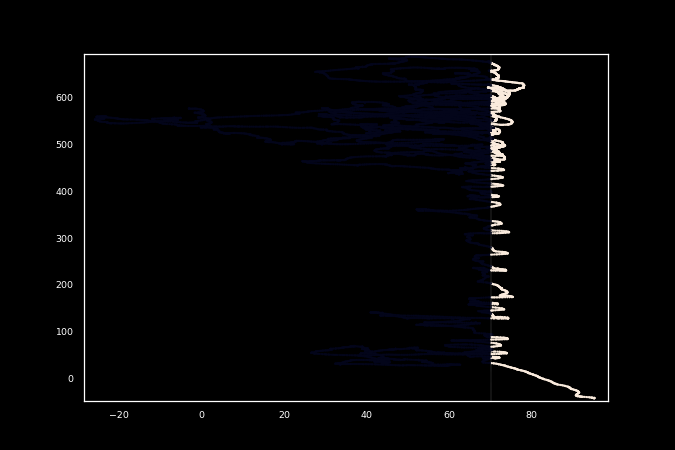

-26.0 96.0 -42.0 689.0


In [330]:
acq_interva1 = d_['time'].diff().mean()*1000
print(acq_interva1)
ani = AnimatedScatter(d_, strip_borders=curr_borders, offset=2.5, cdict=cdict, interval=5, hue_var='instrip')
ani.ani

In [314]:
ani.ani

In [283]:
FFwriter = animation.FFMpegWriter(fps=30)
figname = 'anim_{}'.format( trial_id)
ani_outfile = os.path.join(figdir, '{}.mp4'.format(figname))
ani.ani.save(ani_outfile, writer=FFwriter)
print(ani_outfile)

ValueError: Collections can only map rank 1 arrays